**Understanding the Problem Statement for our Speech-to-Text Project**

Let’s understand the problem statement of our project before we move into the implementation part.

We might be on the verge of having too many screens around us. It seems like every day, new versions of common objects are “re-invented” with built-in wifi and bright touchscreens. A promising antidote to our screen addiction is voice interfaces. 

TensorFlow recently released the Speech Commands Datasets. It includes 65,000 one-second long utterances of 30 short words, by thousands of different people. We’ll build a speech recognition system that understands simple spoken commands.

You can download the dataset from [here](http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz).

**Implementing the Speech-to-Text Model in Python**

The wait is over! It’s time to build our own Speech-to-Text model from scratch.

**Import the libraries**

First, import all the necessary libraries into our notebook. LibROSA and SciPy are the Python libraries used for processing audio signals.

**OBS**

In order to run properly the libraries `sounddevice` and `soundfile`, you must follow this steps:

    1. Install the libportaudio2/portaudio in your SO (apt install libportaudio2/dnf install portaudio - probably it is already installed);
    2. Install the sounddevice library via conda (conda install python-sounddevice);
    3. Remove conda portaudio installation (conda uninstall --force portaudio).

In [3]:
%tensorflow_version 1.4
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2384634275654807221, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3703683077530991044
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3503886275000041579
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17520393229331075543
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import librosa 
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import warnings

#import sounddevice as sd
#import soundfile as sf

from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

In [3]:
os.listdir('/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/')

['train', 'test']

**Data Exploration and Visualization**

Data Exploration and Visualization helps us to understand the data as well as pre-processing steps in a better way. 

**Visualization of Audio signal in time series domain**

Now, we’ll visualize the audio signal in the time series domain:

In [0]:
train_audio_path = '/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/train/'
samples, sample_rate = librosa.load(train_audio_path+'one/0a7c2a8d_nohash_0.wav', sr = 16000)

In [7]:
samples.shape

(16000,)

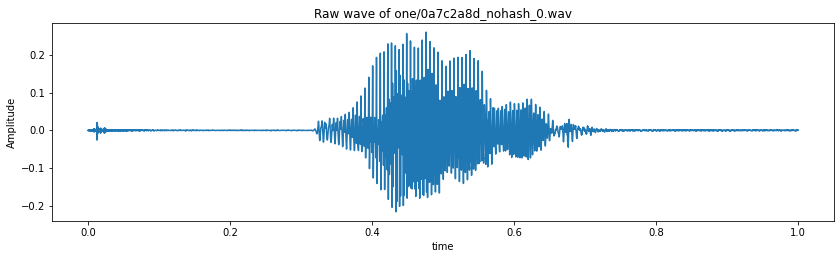

In [9]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'one/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

**Sampling rate **

Let us now look at the sampling rate of the audio signals

In [0]:
ipd.Audio(samples, rate=sample_rate)

In [0]:
print(sample_rate)

16000


**Resampling**

From the above, we can understand that the sampling rate of the signal is 16000 hz. Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000z 

In [0]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Now, let’s understand the number of recordings for each voice command:

In [0]:
labels=os.listdir(train_audio_path)

In [0]:
labels

['tree', 'four', 'five', 'two', 'six', 'one']

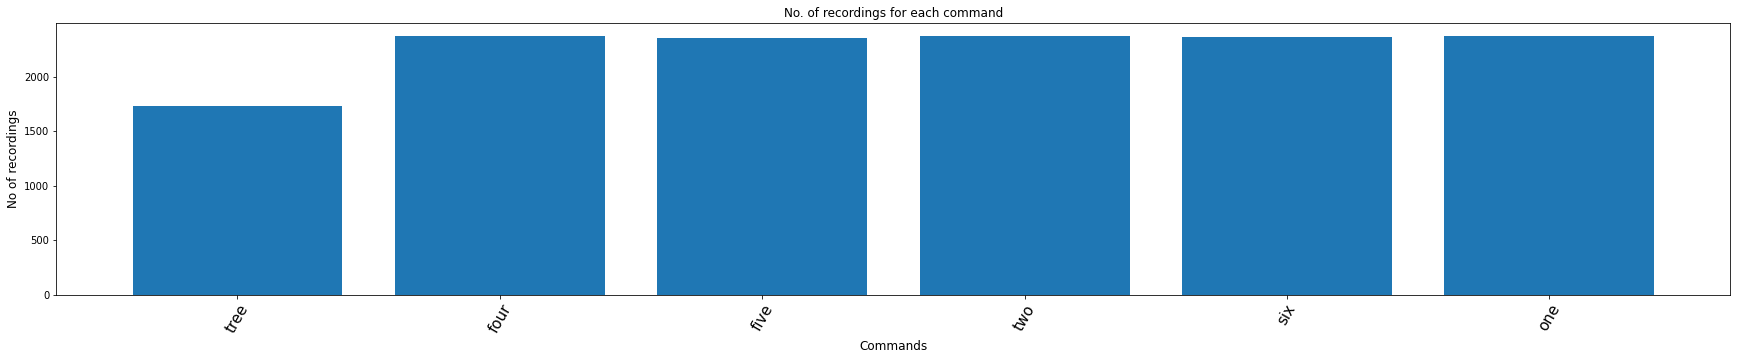

In [0]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in tqdm(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

**Duration of recordings**

What’s next? A look at the distribution of the duration of recordings:

**Preprocessing the audio waves**

In the data exploration part earlier, we have seen that the duration of a few recordings is less than 1 second and the sampling rate is too high. So, let us read the audio waves and use the below-preprocessing steps to deal with this.

Here are the two steps we’ll follow:

* Resampling
* Removing shorter commands of less than 1 second

Let us define these preprocessing steps in the below code snippet:

In [0]:
train_audio_path = '/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/train/'

all_wave = []
all_label = []
duration_of_recordings=[]
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in tqdm(waves):
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        duration_of_recordings.append(float(len(samples)/sample_rate))
        
        samples = librosa.resample(samples, sample_rate, 8000)
        
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

plt.hist(np.array(duration_of_recordings))

tree



four



five



two


Convert the output labels to integer encoded:

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:

In [0]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:

In [0]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation set**

Next, we will train the model on 80% of the data and validate on the remaining 20%:


In [0]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

**Model Architecture for this problem**

We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 

**Model building**

Let us implement the model using Keras functional API.

In [0]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
K.clear_session()

In [0]:
inputs = Input(shape=(8000,1))

In [0]:
inputs

In [0]:
#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Define the loss function to be categorical cross-entropy since it is a multi-classification problem:

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and to save the best model after every epoch:

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/train/best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:

In [0]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

**Diagnostic plot**

I’m going to lean on visualization again to understand the performance of the model over a period of time:

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

In [0]:
print(os.getcwd())

In [0]:
from keras.models import load_model
model=load_model('/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/train/best_model.hdf5')

Define the function that predicts text for the given audio:

In [0]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index], prob

Prediction time! Make predictions on the validation data:

In [0]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

In [0]:
print("Text:",predict(samples))

In [0]:
test_audio_path = '/content/drive/My Drive/Estudos/FIB - PÓS/Aula-38/Numbers/test/'

In [0]:
#reading the voice commands
samples, sample_rate = librosa.load(test_audio_path + 'six/clip_000f49605.wav', sr = 8000)
samples = librosa.resample(samples[-8000:], sample_rate, 8000)

print(predict(samples))

ipd.Audio(samples,rate=8000)

In [0]:
#reading the voice commands
#samples, sample_rate = librosa.load('teste_left.ogg', sr = 8000)
#samples = librosa.resample(samples[-8000:], sample_rate, 8000)

#print(predict(samples))

#ipd.Audio(samples,rate=8000)

The best part is yet to come! Here is a script that prompts a user to record voice commands. Record your own voice commands and test it on the model:

In [0]:
samplerate = 16000  
duration = 1 # seconds
filename = 'online.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

Let us now read the saved voice command and convert it to text:

In [0]:
#reading the voice commands
samples, sample_rate = librosa.load(filename, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [0]:
#converting voice commands to text
predict(samples)

Congratulations! You have just built your very own speech-to-text model!

In [0]:
y_true = [classes[np.argmax(i)] for i in y_val]

In [0]:
prob = np.array([model.predict(i.reshape(1,8000,1)) for i in x_val])

In [0]:
y_pred = [classes[np.argmax(i)] for i in prob]

In [0]:
from sklearn.metrics import classification_report

In [0]:
print(classification_report(y_true, y_pred))

## Classic Machine Learning

### Feature Extraction

In [0]:
mfccs = []
s_lengths = []

for s in tqdm(all_wave):
    
    s_lengths.append(len(s))
    
    #extract mfccs taken the mean and store them.
    mfcc_full = librosa.feature.mfcc(s.reshape(8000,), sr=8000, n_mfcc=13)

    mfcc_mean = np.mean(mfcc_full, axis=1)

    mfcc_std = np.std(mfcc_full, axis=1)

    mfcc_median = np.median(mfcc_full, axis=1)

    mfccs.append(np.concatenate((mfcc_mean, mfcc_std, mfcc_median)))


In [0]:
import pandas as pd
from sklearn import preprocessing


In [0]:
features = pd.DataFrame(mfccs)
# features["size"] = s_lengths

scaler = preprocessing.StandardScaler()

data = pd.DataFrame(scaler.fit_transform(features))

data["y"] = all_label

print(data.shape)
data.head(10)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(["y"], axis=1), data.y, test_size=0.20, random_state=0)

In [0]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [0]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

In [0]:
y_pred = lr.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

In [0]:
y_pred = rf.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred))

In [0]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

In [0]:
y_pred = xgb.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred))